# Negative Fake Companion Technique 
## Using GPU

In [2]:
import matplotlib.pyplot as plt 
import tensorflow as tf 
import tensorflow_addons as tfa
import tensorflow_probability as tfp
import numpy as np
import os

from vip_hci.fits import open_fits

from vip.plottools import create_circular_mask 
from mpl_toolkits.axes_grid1 import make_axes_locatable

import gpu.fake_comp as tfnegfc


os.environ["CUDA_VISIBLE_DEVICES"] = "3"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Loading data

In [106]:
root = './data/HCI/'

cube_route = os.path.join(root, 'center_im.fits')
cube       = open_fits(cube_route, header=False) 

psf_route = os.path.join(root, 'median_unsat.fits')
psf       = open_fits(psf_route, header=False)

ra_route = os.path.join(root, 'rotnth.fits')
rot_ang  = open_fits(ra_route, header=False)
rot_ang  = -rot_ang

lambda_ch = 0 # channel to use
psf_pos   = 0 # psf position

Fits HDU-0 data successfully loaded. Data shape: (2, 90, 201, 201)
Fits HDU-0 data successfully loaded. Data shape: (2, 2, 64, 64)
Fits HDU-0 data successfully loaded. Data shape: (90,)


### Normalizing PSF: Creating a template to mimic companions 

The first step consists in creating the fake companion template we will use later to mimic the real one.

We need first to find the real center and standard deviation of the PSF by fitting a gaussian model on pixels, 

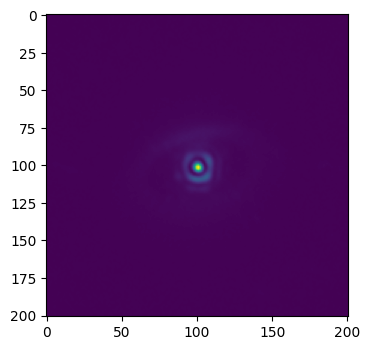

In [107]:
plt.figure(dpi=100)
plt.imshow(cube[0, 0])

In [108]:
results = tfnegfc.adjust_gaussian(psf[lambda_ch, psf_pos])

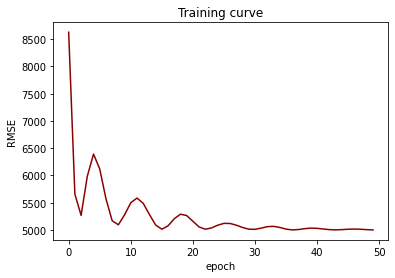

In [109]:
plt.plot(results['history'], color='darkred')
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.title('Training curve')
plt.show()

Assuming an sphere (i.e., same FWHM along the PSFs) we center all the availables PSFs. This is not used yet, but worth for future work:

In [110]:
fwhm_sphere  = tf.reduce_mean(results['fwhm'])
centered_psf = tfnegfc.center_cube(psf[lambda_ch], fwhm_sphere)
centered_psf.shape

TensorShape([2, 64, 64])

Once all the PSFs were aligned we can normalize it to have a 1-FWHM in an aperture equal to FWHM//2

In [111]:
normalized_psf = tfnegfc.normalize_psf(centered_psf, fwhm=fwhm_sphere)

### PCA: Extracting most variable pixels along the time axis from the cube of frames

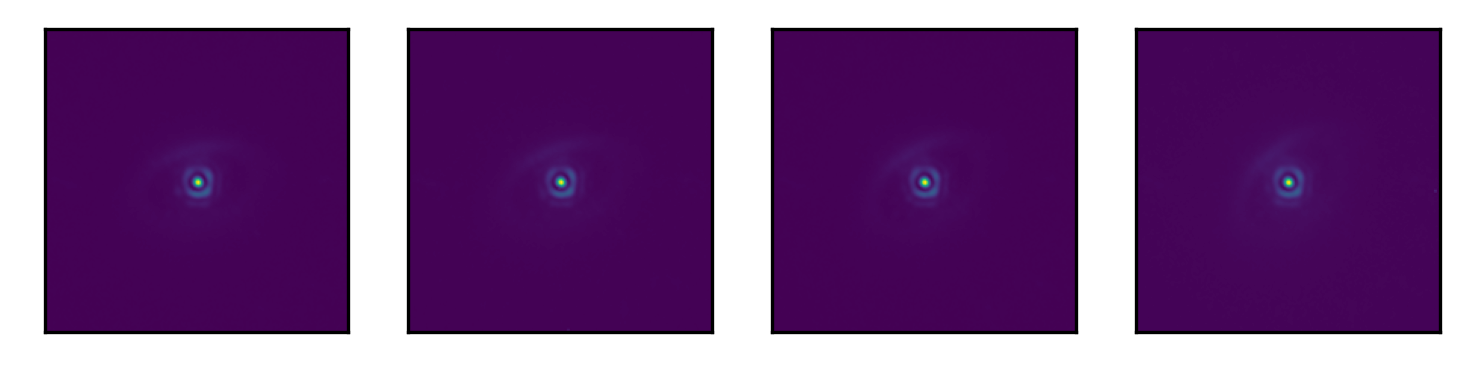

In [112]:
fig, axes = plt.subplots(1, 4, sharex=True, sharey=True, dpi=300)
axes = axes.flatten()
for i, nf in enumerate(range(0, len(cube[0]), 10)):
    try:
        axes[i].imshow(cube[0, nf])
        axes[i].set_xticks([])
        axes[i].set_yticks([])
    except:
        break

In [113]:
cube[0].shape

(90, 201, 201)

In [114]:
%%time
adi_image = tfnegfc.apply_adi(cube[0], rot_ang, out_size=cube[0].shape, ncomp=1, derotate='tf')

CPU times: user 76.1 ms, sys: 20.1 ms, total: 96.3 ms
Wall time: 117 ms


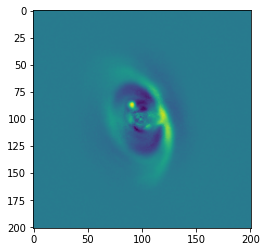

In [115]:
plt.imshow(adi_image)

In [116]:
%%time
table = tfnegfc.get_coords(adi_image.numpy(), fwhm=fwhm_sphere, bkg_sigma=5, cut_size=10)

CPU times: user 4.28 s, sys: 23 ms, total: 4.3 s
Wall time: 4.24 s


In [117]:
table

,x,y,flux,fwhm_mean,snr
0,91.430794,86.833885,3.315128,4.139935,2.715651
1,106.392303,106.029022,1.466272,4.254222,1.737472
2,89.601738,99.557083,1.275042,4.414632,1.308844


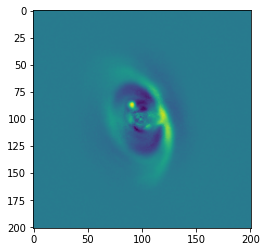

In [118]:
plt.figure()
plt.imshow(adi_image)
plt.show()

### Fiting parameters

In [119]:
from tensorflow.keras.optimizers import Adam 
from gpu.negfc_models import get_model
from gpu.losses import custom_loss
from gpu.data import get_dataset

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [285]:
def wrapper(fn, fwhm):
    def inner(*args):
        out = fn(*args, fwhm=fwhm)
        return out
    return inner

In [286]:
custom_loss_w = wrapper(custom_loss, fwhm=table.iloc[0]['fwhm_mean'])

dataset, recovery = get_dataset(cube, normalized_psf, rot_ang, normalize=0)

model = get_model(x_init=table.iloc[0]['x'], 
                  y_init=table.iloc[0]['y'], 
                  cube=cube)    

model.compile(loss_fn=custom_loss_w, optimizer=Adam(1))
# model.summary()

(41.43079376220703, 141.43079376220703)

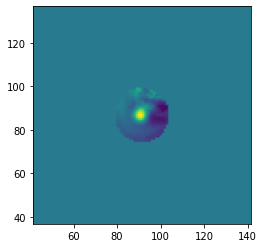

In [287]:
x_ = table.iloc[0]['x']
y_ = table.iloc[0]['y']
fwhm_ = table.iloc[0]['fwhm_mean']

obj_reg = tfnegfc.get_objective_region(adi_image, x_, y_, rot_ang, fwhm_*3)
plt.figure()
plt.imshow(obj_reg[0])
plt.ylim(y_-50, y_+50)
plt.xlim(x_-50, x_+50)

In [288]:
%%time
hist = model.fit(dataset, epochs=150, verbose=1)

Epoch 1/150
1/1 [==============================] - 3s 3s/step - loss: 1.3144
Epoch 2/150
1/1 [==============================] - 0s 205ms/step - loss: 1.2849
Epoch 3/150
1/1 [==============================] - 0s 210ms/step - loss: 1.2562
Epoch 4/150
1/1 [==============================] - 0s 213ms/step - loss: 1.2279
Epoch 5/150
1/1 [==============================] - 0s 215ms/step - loss: 1.1997
Epoch 6/150
1/1 [==============================] - 0s 222ms/step - loss: 1.1716
Epoch 7/150
1/1 [==============================] - 0s 202ms/step - loss: 1.1442
Epoch 8/150
1/1 [==============================] - 0s 206ms/step - loss: 1.1179
Epoch 9/150
1/1 [==============================] - 0s 206ms/step - loss: 1.0916
Epoch 10/150
1/1 [==============================] - 0s 217ms/step - loss: 1.0659
Epoch 11/150
1/1 [==============================] - 0s 216ms/step - loss: 1.0404
Epoch 12/150
1/1 [==============================] - 0s 228ms/step - loss: 1.0157
Epoch 13/150
1/1 [======================

1/1 [==============================] - 0s 210ms/step - loss: 0.1668
Epoch 103/150
1/1 [==============================] - 0s 207ms/step - loss: 0.1660
Epoch 104/150
1/1 [==============================] - 0s 208ms/step - loss: 0.1651
Epoch 105/150
1/1 [==============================] - 0s 213ms/step - loss: 0.1644
Epoch 106/150
1/1 [==============================] - 0s 197ms/step - loss: 0.1637
Epoch 107/150
1/1 [==============================] - 0s 209ms/step - loss: 0.1630
Epoch 108/150
1/1 [==============================] - 0s 210ms/step - loss: 0.1624
Epoch 109/150
1/1 [==============================] - 0s 222ms/step - loss: 0.1619
Epoch 110/150
1/1 [==============================] - 0s 214ms/step - loss: 0.1614
Epoch 111/150
1/1 [==============================] - 0s 212ms/step - loss: 0.1609
Epoch 112/150
1/1 [==============================] - 0s 215ms/step - loss: 0.1605
Epoch 113/150
1/1 [==============================] - 0s 205ms/step - loss: 0.1601
Epoch 114/150
1/1 [===========

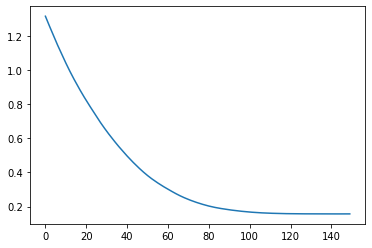

In [290]:
plt.plot(hist.history['loss'])

In [291]:
x_firstguess = model.trainable_variables[0]
y_firstguess = model.trainable_variables[1]
flux_firstguess = model.trainable_variables[2]#*(maxv[0]-minv[0]) + minv[0]
flux_firstguess = flux_firstguess[0]
print('flux: {}'.format(flux_firstguess))

flux: 83.16545104980469


In [292]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_zeros = tfnegfc.inject_fake(x=x, y=y, flux = -flux, 
                                cube=tf.zeros_like(cube[0]), 
                                patch=patch, 
                                rot_angles=rot_ang)
adi_image_fake_zeros = tfnegfc.apply_adi(fake_zeros, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

fake_cube = tfnegfc.inject_fake(x=x, y=y, flux = -flux, 
                                cube=cube[0], 
                                patch=patch, 
                                rot_angles=rot_ang)

adi_image_fake = tfnegfc.apply_adi(fake_cube, 
                                   rot_ang, 
                                   out_size=(cube[0].shape),
                                   ncomp=1, 
                                   derotate='tf')

Text(0.5, 1.0, 'Residuals')

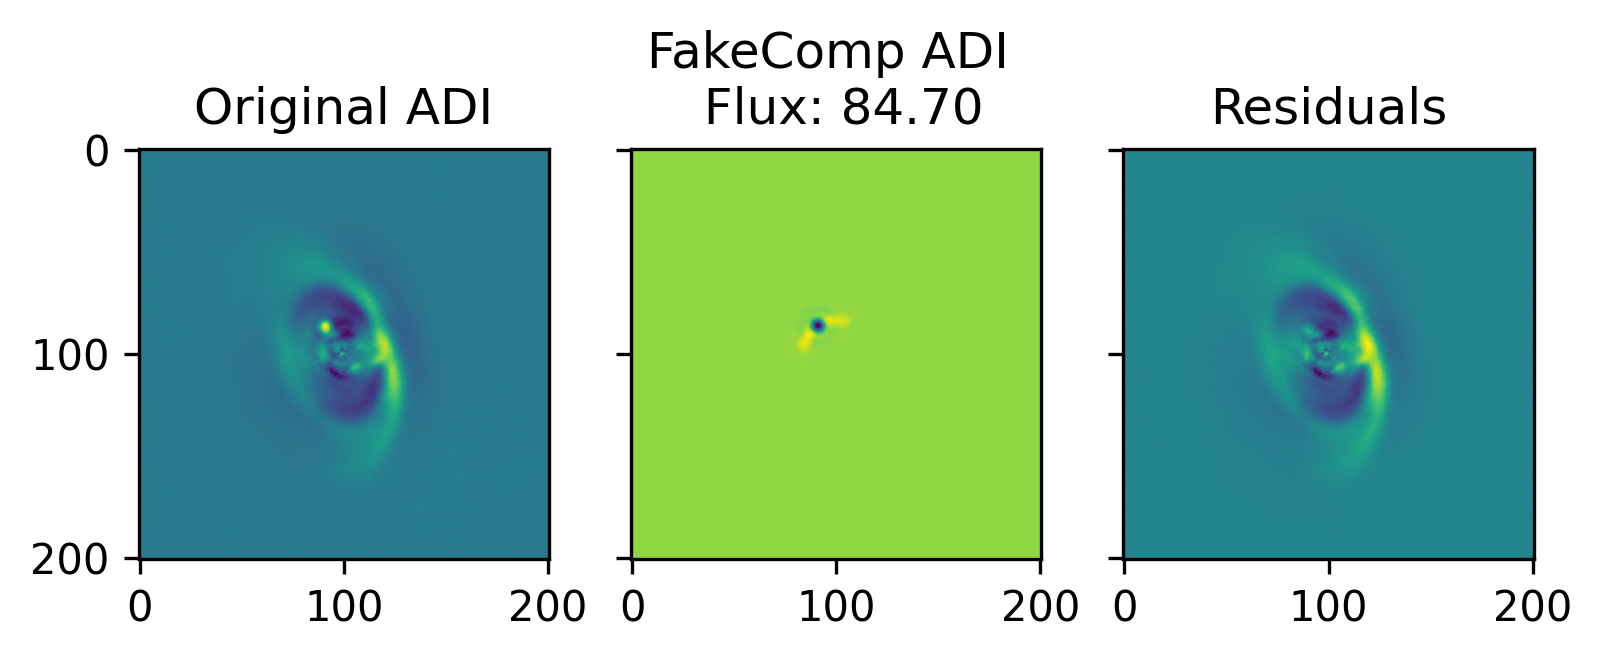

In [293]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, dpi=300)
axes[0].imshow(adi_image)
axes[0].set_title('Original ADI')
axes[1].imshow(adi_image_fake_zeros)
axes[1].set_title('FakeComp ADI \n Flux: {:.2f}'.format(flux))
axes[2].imshow(adi_image+adi_image_fake_zeros)
axes[2].set_title('Residuals')
# plt.scatter(x, y, marker='x', color='red')

### MCMC

In [294]:
from gpu.mcmc import run_chain, run_chain_only_flux

In [295]:
# %%time
# init_state = [x_firstguess.numpy()[0], y_firstguess.numpy()[0], flux_firstguess]
# results = run_chain(init_state, fwhm_*2, cube[0], normalized_psf[0], 
#                     rot_ang, num_results=10000)
# titles = ['x', 'y', 'flux']

In [298]:
%%time
init_state = [flux]

results = run_chain_only_flux(init_state, 
                              x, 
                              y, 
                              table.iloc[0]['fwhm_mean']*3, 
                              cube[0], 
                              normalized_psf[0], 
                              rot_ang, 
                              num_results=5000)
titles = ['flux']

CPU times: user 1min 57s, sys: 11.1 s, total: 2min 8s
Wall time: 51.1 s


In [299]:
start = 0
samples = [r[start:] for r in results.all_states]
opt_values = [np.mean(samples_chain) for samples_chain in samples]

for initial_val, final_val in zip(init_state, opt_values):
    print(initial_val,' - ', final_val)

tf.Tensor(84.69686, shape=(), dtype=float32)  -  77.39975


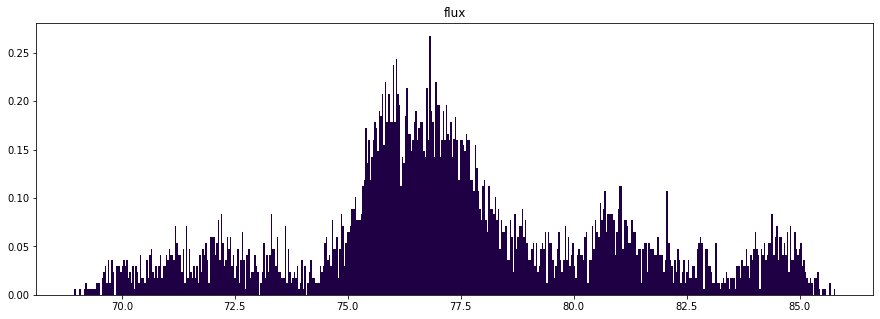

In [300]:
fig, axes = plt.subplots(1, len(init_state), figsize=(15,5))
if len(init_state)>1: 
    axes = axes.flatten()
else:
    axes = [axes]
    
for i, r in enumerate(samples):
    axes[i].hist(np.ravel(r), bins=500, color='#200044', density=True)
    axes[i].set_title(titles[i])

## Visualizing Results

In [301]:
try:
    x_star = opt_values[0]
    y_star = opt_values[1]
    flux_star = opt_values[2]
except:
    x_star = x_firstguess.numpy()[0]
    y_star = y_firstguess.numpy()[0]
    flux_star = opt_values[0]

In [302]:
x_star, y_star, flux_star

(91.43079, 86.833885, 77.39975)

In [303]:
patch = tfnegfc.create_patch(cube[0, 0], normalized_psf[0])

fake_cube = tfnegfc.inject_fake(x = x_star, 
                                y = y_star, 
                                flux  = -flux_star, 
                                cube  = cube[0], 
                                patch = patch, 
                                rot_angles = rot_ang)

fake_cube_adi = tfnegfc.apply_adi(fake_cube, 
                                  rot_ang, 
                                  out_size=(cube[0].shape),
                                  ncomp=1, 
                                  derotate='tf')

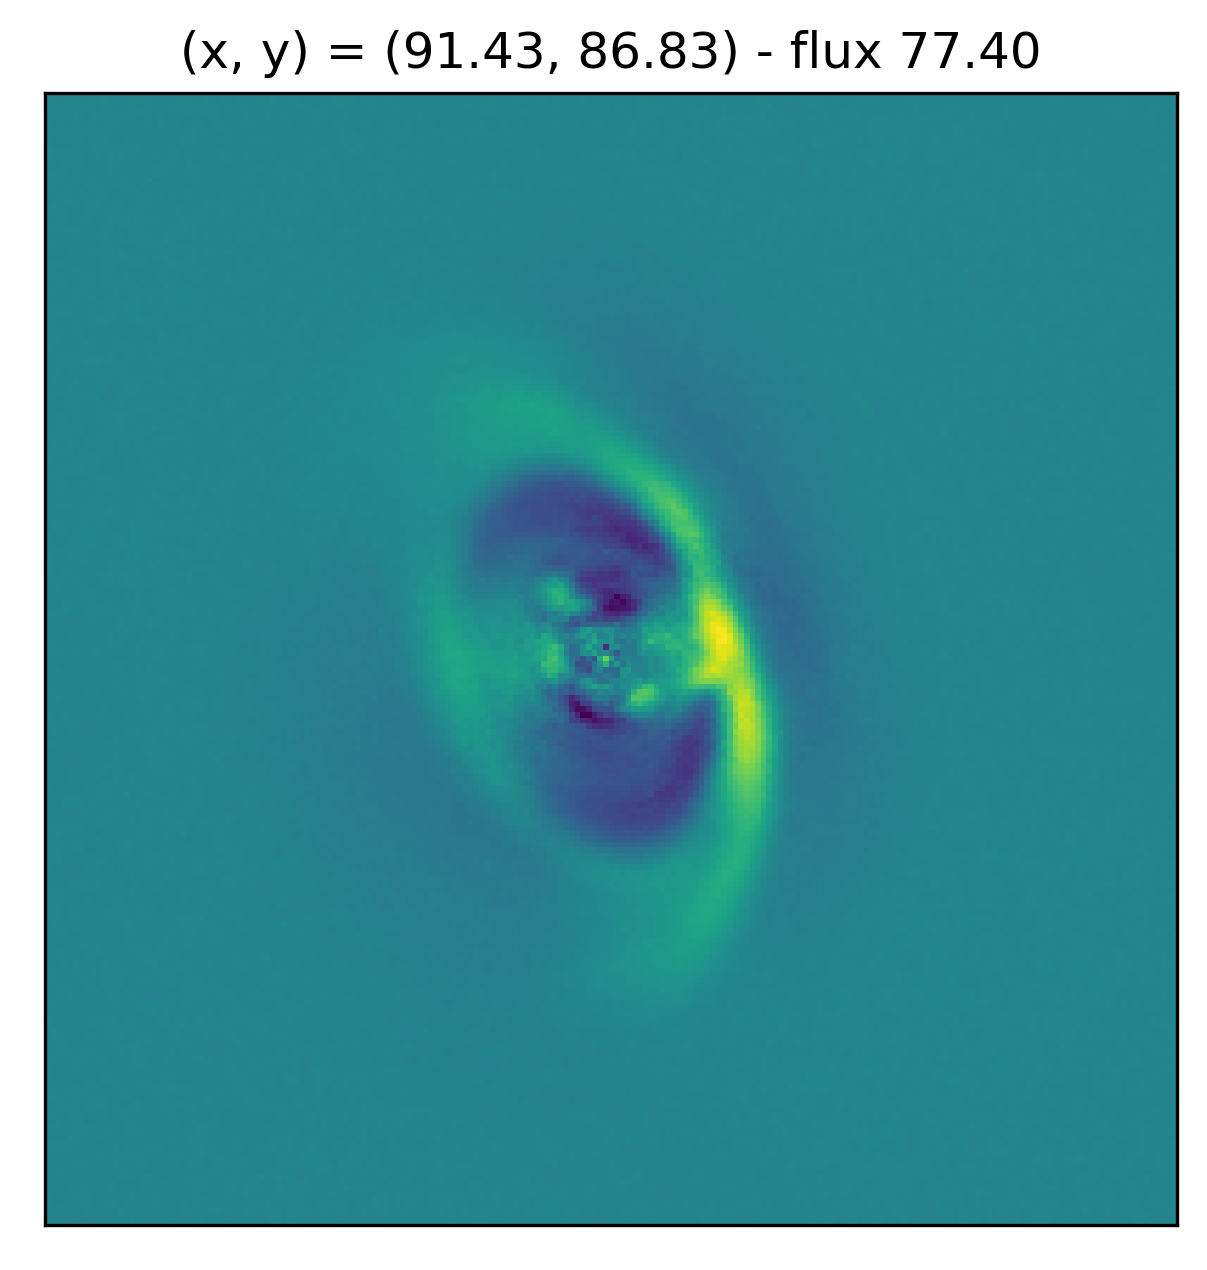

In [308]:
plt.figure(figsize=(5,5),dpi=300)
plt.imshow(fake_cube_adi)
plt.title('(x, y) = ({:.2f}, {:.2f}) - flux {:.2f}'.format(x_star, y_star, flux_star))
plt.xticks([])
plt.yticks([])
plt.show()